## Finding TF code as a set cover problem

For a given set of cell clusters, the task of finding the minimal set of genes required to make every cluster distinguishable from each other can be framed as a [set cover problem](https://en.wikipedia.org/wiki/Set_cover_problem).
In this context, The universe is the collection of all possible pairs of clusters that need to be distinguished. Each gene represents a set, which "covers" any pair of clusters that it can distinguish based on its expression pattern.The goal is to find the smallest collection of genes that collectively covers all pairs, thereby ensuring every cluster has a unique expression signature.

This is an NP-hard problem, which means no efficient algorithm is known to find the guaranteed optimal solution for large datasets. However, approximation algorithms, such as the greedy algorithm, can provide a near-optimal solution efficiently.

The greedy algorithm works by iteratively building a solution. It starts with a pool of all indistinguishable pairs and, in each step, selects the single most effective gene—the one that distinguishes the largest number of pairs still in the pool. This gene is added to the solution set, the pairs it covers are removed from the pool, and the process repeats until all pairs are distinguished.

![Greedy search](Greedy_search.png)

To apply this framework, we first simplify the data by binarizing gene expression. A gene is considered "on" in a cluster only if it meets thresholds for both coverage and normalized pseudo-bulk expression level.

The cutoffs are:
**coverage**: 0.5
**Norm. expression**: 0.2

> **Note**: This approach is distinct from finding the minimal combination of genes required to identify a single, specific cluster.


In [50]:
# Binarize cluster/TF matrix based on both coverage and expression level
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## define data paths, locally on Yijie's mac
expression_level_file = "/Users/yijiep/Desktop/najia_data/spatial_tf_exp.csv"
coverage_file = "/Users/yijiep/Desktop/najia_data/counts_summary_awasakiltfs91.csv"

## data preprocessing
### read in expression level data
bulk_expression_level = pd.read_csv(expression_level_file, index_col=0)
### remove "g" from row names if stats with it
old_index = bulk_expression_level.index
new_index = [name[1:] if name.startswith("g") else name for name in old_index]
bulk_expression_level.index = new_index
### convert bulk_expression_level to a long format
bulk_expression_level = bulk_expression_level.reset_index().melt(id_vars='index', var_name='gene', value_name='expression')
bulk_expression_level = bulk_expression_level.rename(columns={'index': 'cluster'})

### read in coverage data
coverage = pd.read_csv(coverage_file, index_col=0)
coverage = coverage.rename(columns={'new_clusters': 'cluster'})

### Joint expression level into coverage dataframe
combined = coverage.merge(bulk_expression_level, on=['cluster', 'gene'], how='left')

combined['expression_norm'] = combined.groupby('gene')['expression'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else x
)

### Binarize the data by a coverage cut off (0.5) and normalized expression level cut off (0.2)
combined['binary'] = np.where((combined['frac.of.expr.cells.per.cluster'] >= 0.5) & (combined['expression_norm'] >= 0.2), 1, 0)

### create a binary matrix for greedy set cover
binary_matrix = combined.pivot(index='gene', columns='cluster', values='binary')


In [78]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def make_dot_plot(data_df,
                    hue_col='expression_norm',
                    coverage_col='frac.of.expr.cells.per.cluster',
                    cluster_col='cluster',
                    gene_col='gene',
                    cluster_order=None,
                    gene_order=None,
                    coverage_bins=None,
                    size_scale=None,
                    cmap='magma_r',
                    cbar_pos=[0.9, 0.6, 0.015, 0.25],
                    legend_pos=[0.9, 0.3, 0.015, 0.25],
                    highlight_clusters=None):
    """
    Generates a highly customizable dot plot from a long-format DataFrame.

    Args:
        data_df (pd.DataFrame): Long-format DataFrame with plot data.
        ... (other args) ...
        highlight_clusters (set, optional): A set of cluster labels to highlight in red.

    Returns:
        matplotlib.figure.Figure: The figure object containing the dot plot.
    """
    # Set defaults
    if coverage_bins is None:
        coverage_bins = [0, 0.1, 0.25, 0.5, 0.75, 1.0]
    if size_scale is None:
        radii = np.array([0, 1, 3, 6, 9])
        size_scale = (radii**2) * 1
        
    if len(size_scale) != len(coverage_bins) - 1:
        raise ValueError("size_scale length must be one less than coverage_bins.")

    plot_data = data_df.copy()

    # Set categorical types for ordering
    if cluster_order is not None:
        plot_data[cluster_col] = pd.Categorical(plot_data[cluster_col], categories=cluster_order, ordered=True)
    if gene_order is not None:
        plot_data[gene_col] = pd.Categorical(plot_data[gene_col], categories=gene_order, ordered=True)

    # 1. Digitize coverage data for dot sizes
    size_labels = [f'{coverage_bins[i]*100:.0f}-{coverage_bins[i+1]*100:.0f}%' for i in range(len(coverage_bins)-1)]
    plot_data['size_cat'] = pd.cut(plot_data[coverage_col], bins=coverage_bins, labels=size_labels, right=True, include_lowest=True)
    size_map = dict(zip(size_labels, size_scale))

    # 2. Create the plot
    fig_width = max(10, 0.2 * plot_data[gene_col].nunique())
    fig_height = max(8, 0.2 * plot_data[cluster_col].nunique())
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Adjust main plot to make space on the right
    fig.subplots_adjust(right=0.85)

    # Create the scatter plot but disable the default legend
    sns.scatterplot(
        data=plot_data, x=gene_col, y=cluster_col, hue=hue_col,
        size='size_cat', sizes=size_map, palette=cmap, ax=ax,
        marker='o', edgecolor='none', legend=False
    )

    # 3. Customize appearance
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Gene', fontweight='bold')
    ax.set_ylabel('Cluster', fontweight='bold')
    ax.set_title('Gene Expression and Coverage Dot Plot', fontweight='bold')
    
    if not cluster_order:
        ax.invert_yaxis()

    # Highlight specified cluster labels
    if highlight_clusters:
        for label in ax.get_yticklabels():
            if label.get_text() in highlight_clusters:
                label.set_color('red')

    # 4. Create Color Bar in a dedicated Axes
    cax = fig.add_axes(cbar_pos)
    norm = mcolors.Normalize(vmin=plot_data[hue_col].min(), vmax=plot_data[hue_col].max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, cax=cax, orientation='vertical', ticks=[0,1])
    cbar.set_label('Norm. Expression', fontweight='bold')
    cbar.ax.set_yticklabels(['Min', 'Max'])
    cbar.outline.set_visible(False)

    # 5. Create Size Legend in a dedicated Axes
    lax = fig.add_axes(legend_pos)
    size_legend_handles = [plt.scatter([], [], s=s, color='gray', marker='o', edgecolor='none') for s in size_scale]
    lax.legend(handles=size_legend_handles, labels=size_labels,
               loc='center', title='Coverage', frameon=False)
    lax.axis('off') # Hide the axes box

    return fig

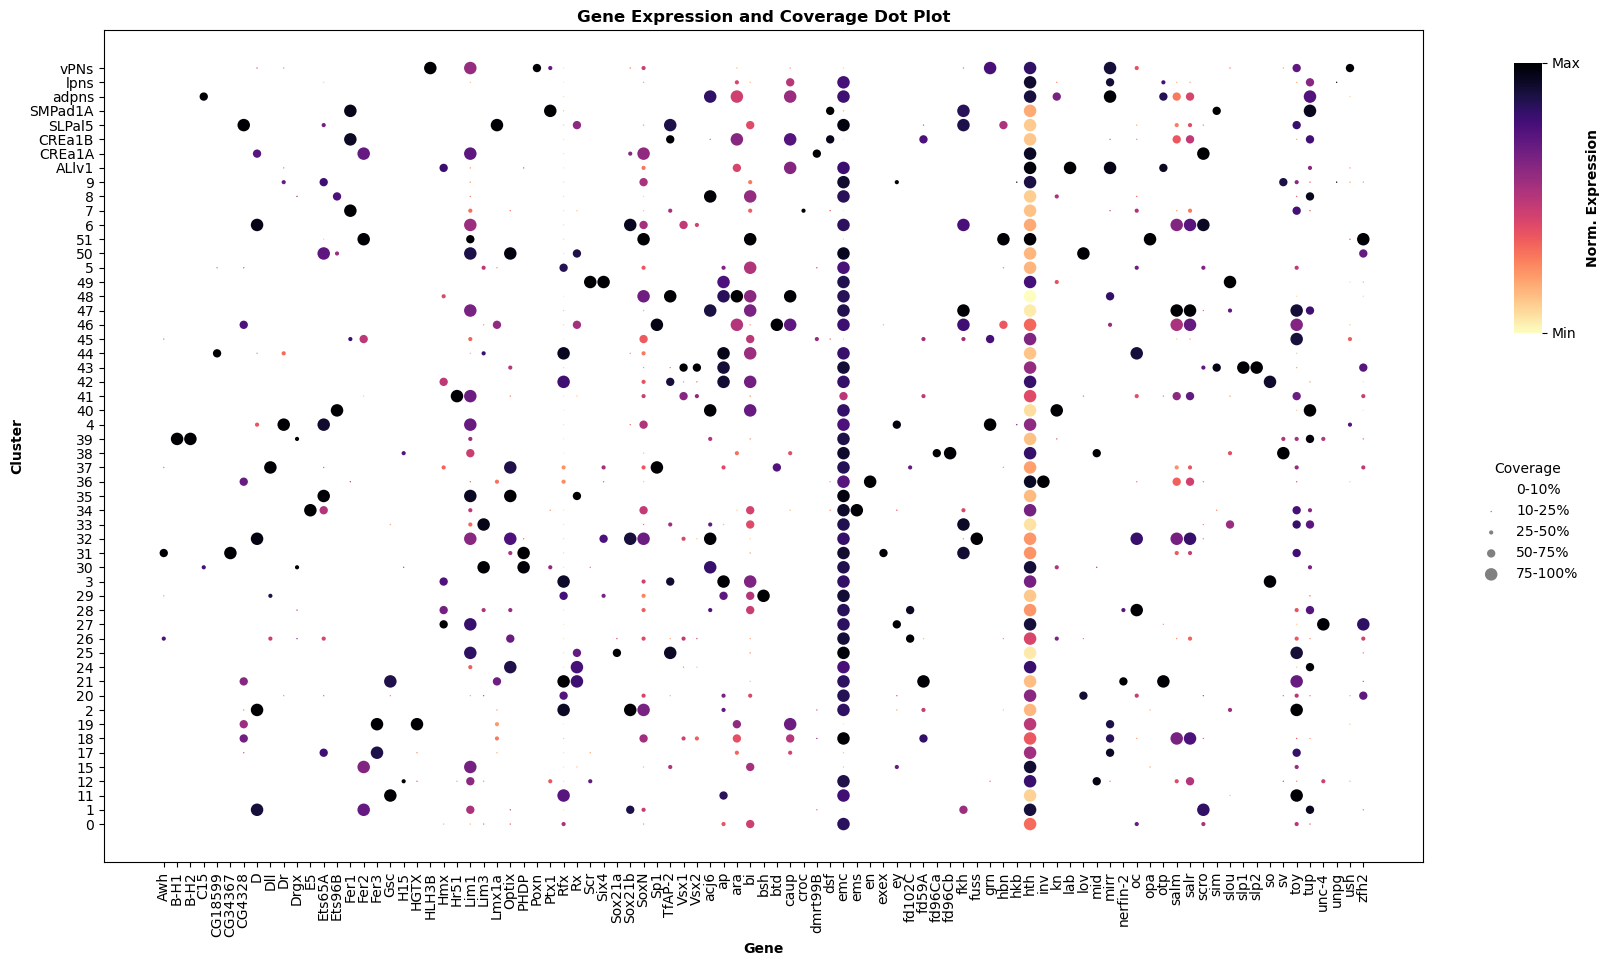

In [45]:
fig = make_dot_plot(combined)
plt.show()

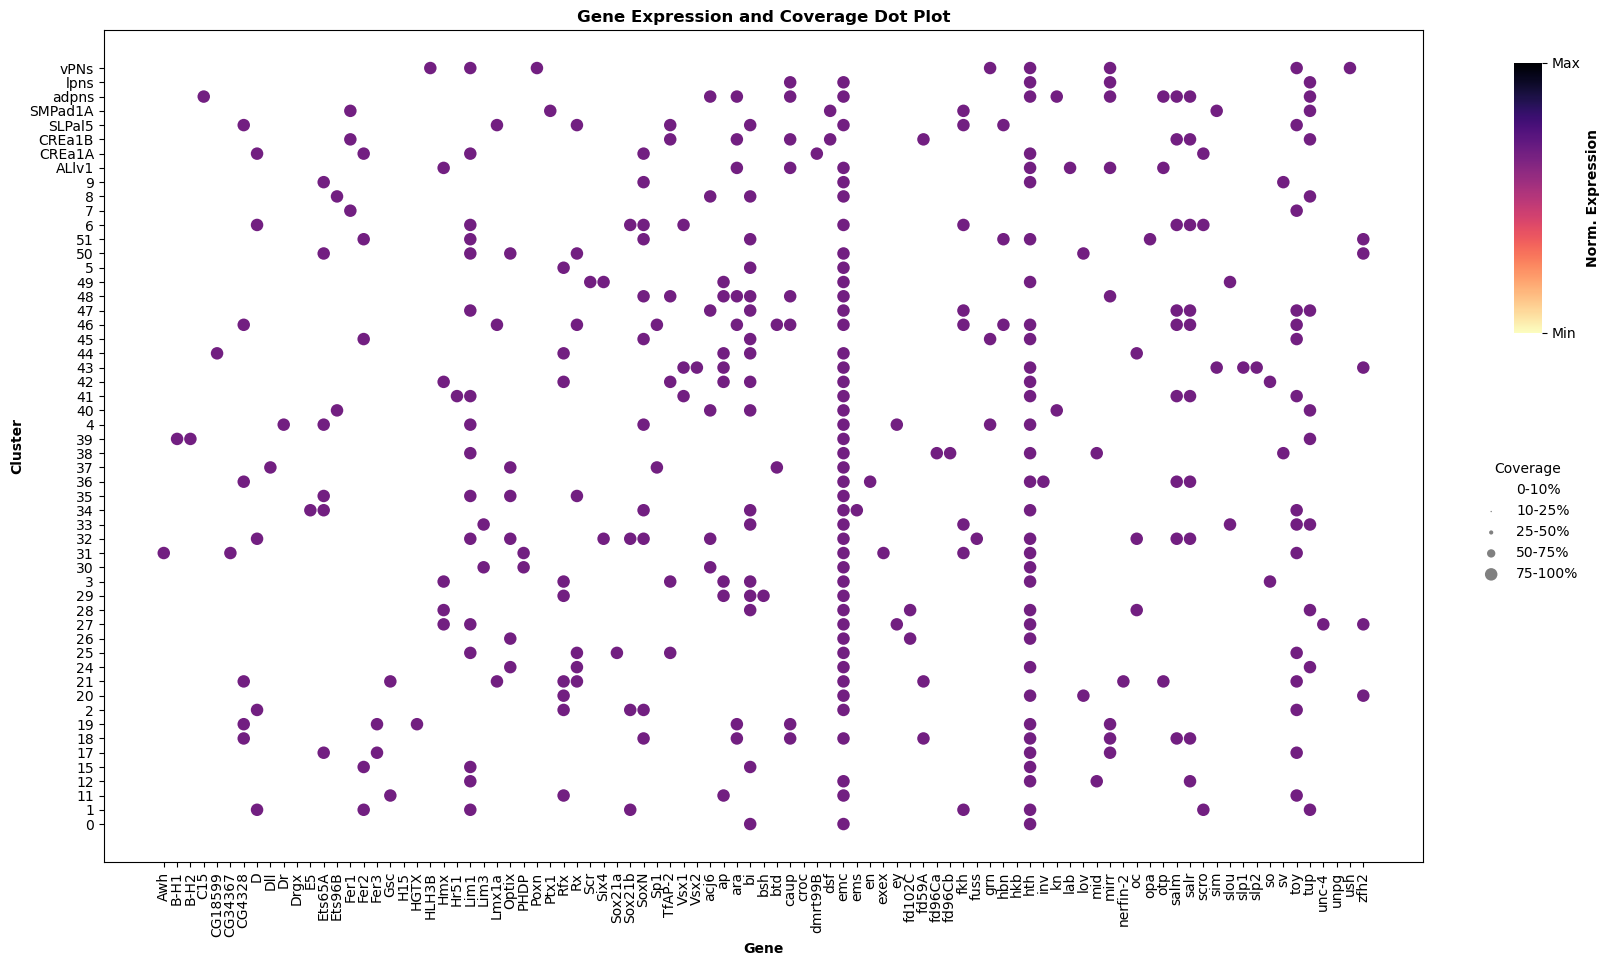

In [48]:
fig = make_dot_plot(combined, hue_col='binary', coverage_col='binary')
plt.show()

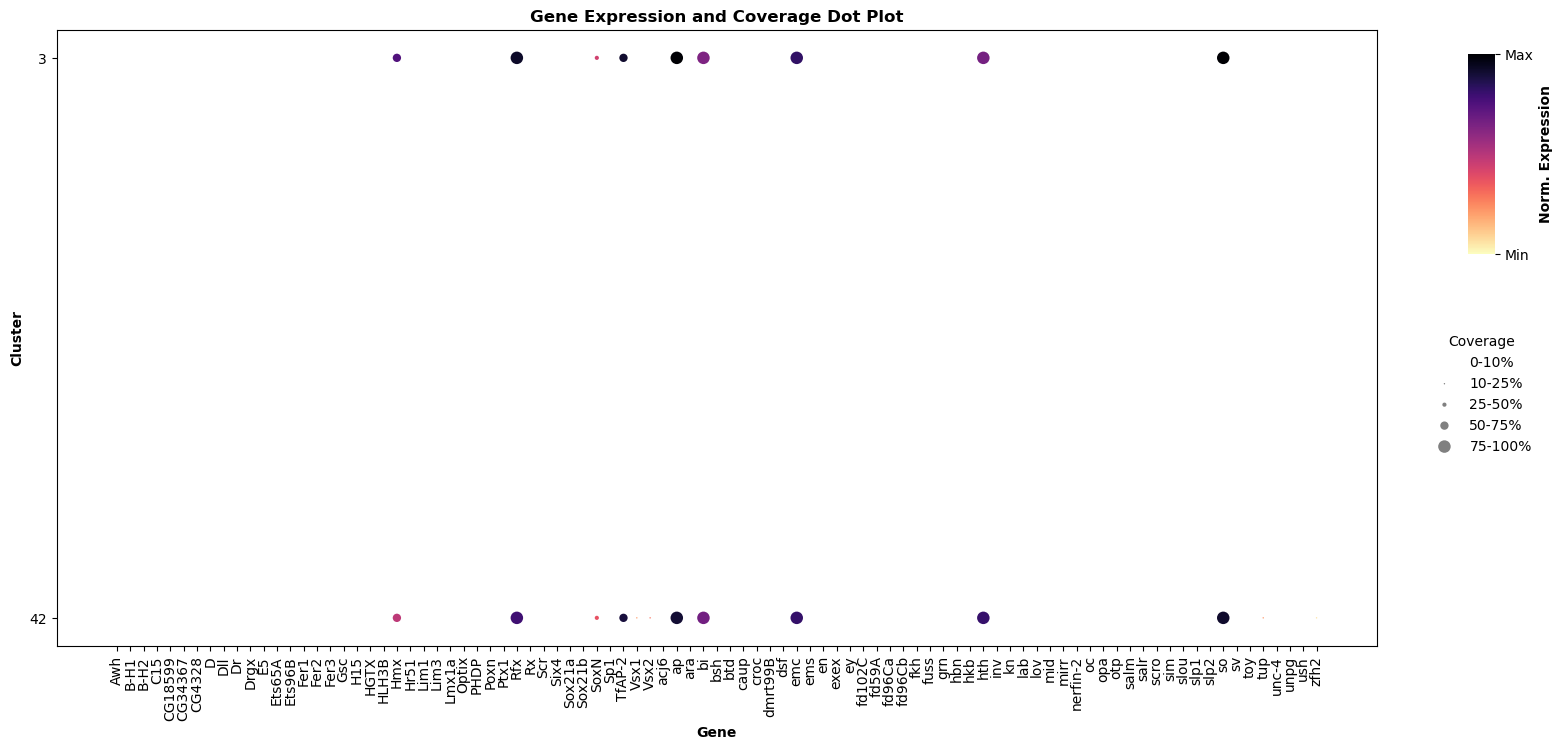

In [67]:
fig = make_dot_plot(combined, cluster_order=['3','42'])
plt.show()

In [ ]:
def find_features_greedy_set_cover_with_initial(matrix, initial_features=None):
    """
    Finds a near-optimal feature set using the greedy set cover algorithm, starting with a set of initial features.

    Args:
        matrix (np.ndarray): Binary matrix of shape (num_clusters, num_features).
        initial_features (list or set, optional): Indices of features to keep initially. Defaults to None.

    Returns:
        dict: Contains the full set of features needed, time taken, and number of unidentified pairs.
    """
    import time
    from itertools import combinations
    print("\nRunning Greedy Set Cover algorithm with initial features...")
    start_time = time.time()
    all_indices = np.arange(len(matrix))
    pairs_to_distinguish = set(combinations(all_indices, 2))
    initial_pair_count = len(pairs_to_distinguish)
    print(f"  - Identified {initial_pair_count} unique pairs of clusters to distinguish.")

    if initial_features is None:
        initial_features = set()
    else:
        initial_features = set(initial_features)

    selected_features = set(initial_features)
    available_features = [i for i in range(matrix.shape[1]) if i not in selected_features]

    # Remove pairs already distinguished by initial features
    # run greedy set cover on initial, and rerank inital by how many pairs they distinguish
    
    for feature_idx in initial_features:
        distinguished = set()
        for cluster1_idx, cluster2_idx in pairs_to_distinguish:
            if matrix[cluster1_idx, feature_idx] != matrix[cluster2_idx, feature_idx]:
                distinguished.add((cluster1_idx, cluster2_idx))
        pairs_to_distinguish -= distinguished

    print(f"  - Initial features distinguish {initial_pair_count - len(pairs_to_distinguish)} pairs. {len(pairs_to_distinguish)} pairs remaining.")

    # Greedy selection for remaining pairs
    while pairs_to_distinguish:
        best_feature = -1
        best_feature_score = -1
        distinguished_by_best = set()

        for feature_idx in available_features:
            distinguishes_now = set()
            for cluster1_idx, cluster2_idx in pairs_to_distinguish:
                if matrix[cluster1_idx, feature_idx] != matrix[cluster2_idx, feature_idx]:
                    distinguishes_now.add((cluster1_idx, cluster2_idx))
            if len(distinguishes_now) > best_feature_score:
                best_feature_score = len(distinguishes_now)
                best_feature = feature_idx
                distinguished_by_best = distinguishes_now

        if best_feature == -1:
            print("  - Warning: Some clusters are indistinguishable with the given features.")
            break
        if best_feature_score == 0:
            print("  - Warning: No further pairs can be distinguished with remaining features.")
            break

        selected_features.add(best_feature)
        available_features.remove(best_feature)
        pairs_to_distinguish -= distinguished_by_best
        # if beast_feature_score is 
        print(f"  - Selected Feature {best_feature}. Distinguishes {best_feature_score} new pairs. {len(pairs_to_distinguish)} pairs remaining.")

    end_time = time.time()
    return {
        "features": sorted(list(selected_features)),
        "time": end_time - start_time,
        "unidentified_pairs": list(pairs_to_distinguish)
    }


In [68]:
from itertools import combinations
import time

def _run_greedy_step(matrix, pairs_to_distinguish, available_features):
    """Helper function to perform one round of greedy selection."""
    best_feature = -1
    best_score = -1
    distinguished_by_best = set()

    # Find the best feature in the current available set
    for feature_idx in available_features:
        # Calculate how many of the *remaining* pairs this feature can distinguish
        score = sum(1 for c1, c2 in pairs_to_distinguish if matrix[c1, feature_idx] != matrix[c2, feature_idx])
        
        if score > best_score:
            best_score = score
            best_feature = feature_idx

    # If a best feature was found, calculate the set of pairs it distinguishes
    if best_feature != -1:
        for c1, c2 in pairs_to_distinguish:
            if matrix[c1, best_feature] != matrix[c2, best_feature]:
                distinguished_by_best.add((c1, c2))
                
    return best_feature, best_score, distinguished_by_best

def ranked_greedy_search(matrix, initial_features=None):
    """
    Performs a two-phase ranked greedy set cover.
    
    Phase 1: Ranks the initial features by greedily selecting from them.
    Phase 2: Continues the greedy search on the remaining features.

    Args:
        matrix (np.ndarray): Binary matrix of shape (num_clusters, num_features).
        initial_features (list or set, optional): Indices of features to use in Phase 1.

    Returns:
        dict: Contains the ranked list of all selected features, time taken, and any unidentified pairs.
    """
    start_time = time.time()
    num_clusters = matrix.shape[0]
    
    # Universe of all pairs that need to be distinguished
    pairs_to_distinguish = set(combinations(range(num_clusters), 2))
    initial_pair_count = len(pairs_to_distinguish)
    print(f"Total pairs to distinguish: {initial_pair_count}")

    if initial_features is None:
        initial_features = set()
    else:
        initial_features = set(initial_features)
        
    all_feature_indices = set(range(matrix.shape[1]))
    remaining_features = all_feature_indices - initial_features

    ranked_selection = []

    # --- Phase 1: Greedily select from and rank the initial features ---
    print("\n--- Phase 1: Ranking initial features ---")
    available_initial = set(initial_features)
    while pairs_to_distinguish and available_initial:
        best_feature, best_score, distinguished_pairs = _run_greedy_step(matrix, pairs_to_distinguish, available_initial)
        
        if best_feature == -1 or best_score == 0:
            print("  - No more pairs can be distinguished by the initial set.")
            break
            
        ranked_selection.append({'feature_index': best_feature, 'score': best_score, 'phase': 1})
        pairs_to_distinguish -= distinguished_pairs
        available_initial.remove(best_feature)
        print(f"  - Selected: Feature {best_feature} (Score: {best_score}). Pairs remaining: {len(pairs_to_distinguish)}")

    # --- Phase 2: Greedily select from the rest of the features ---
    print("\n--- Phase 2: Selecting from remaining features ---")
    available_remaining = set(remaining_features)
    while pairs_to_distinguish and available_remaining:
        best_feature, best_score, distinguished_pairs = _run_greedy_step(matrix, pairs_to_distinguish, available_remaining)

        if best_feature == -1 or best_score == 0:
            print("  - No more pairs can be distinguished by any remaining features.")
            break
            
        ranked_selection.append({'feature_index': best_feature, 'score': best_score, 'phase': 2})
        pairs_to_distinguish -= distinguished_pairs
        available_remaining.remove(best_feature)
        print(f"  - Selected: Feature {best_feature} (Score: {best_score}). Pairs remaining: {len(pairs_to_distinguish)}")

    if pairs_to_distinguish:
        print(f"\nWarning: {len(pairs_to_distinguish)} pairs could not be distinguished.")

    end_time = time.time()
    return {
        "ranked_features": ranked_selection,
        "time": end_time - start_time,
        "unidentified_pairs": list(pairs_to_distinguish)
    }

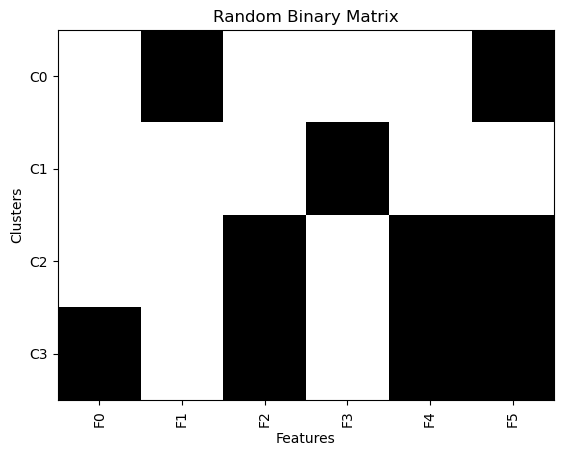


Running Greedy Set Cover algorithm with initial features...
  - Identified 6 unique pairs of clusters to distinguish.
  - Initial features distinguish 0 pairs. 6 pairs remaining.
  - Selected Feature 2. Distinguishes 4 new pairs. 2 pairs remaining.
  - Selected Feature 0. Distinguishes 1 new pairs. 1 pairs remaining.
  - Selected Feature 1. Distinguishes 1 new pairs. 0 pairs remaining.


In [60]:
# test the greedy set cover with initial features
## A random 4x6 binary matrix
np.random.seed(42)
test_matrix = np.random.randint(0, 2, size=(4, 6))

## visualize the test matrix
plt.imshow(test_matrix, cmap='Greys', aspect='auto')
plt.xticks(ticks=np.arange(test_matrix.shape[1]), labels=[f'F{i}' for i in range(test_matrix.shape[1])], rotation=90)
plt.yticks(ticks=np.arange(test_matrix.shape[0]), labels=[f'C{i}' for i in range(test_matrix.shape[0])])
plt.title('Random Binary Matrix')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show() 
result = find_features_greedy_set_cover_with_initial(test_matrix, initial_features=[])

In [70]:
# find the TF set with initial:
intial_tfs = ("fd59A",
            "TfAP-2",
            "ap",
            "exex",
            "Fer1",
            "dsf",
            "ey",
            "Fer2",
            "otp",
            "Vsx2", 
            "hth",
            "acj6")
initial_tf_indices = [list(binary_matrix.index).index(tf) for tf in intial_tfs if tf in list(binary_matrix.index)]

# Note: Your matrix has genes as rows, so we transpose it with .T
ranked_result = ranked_greedy_search(binary_matrix.values.T, initial_features=initial_tf_indices)

Total pairs to distinguish: 1431

--- Phase 1: Ranking initial features ---
  - Selected: Feature 65 (Score: 693). Pairs remaining: 738
  - Selected: Feature 42 (Score: 184). Pairs remaining: 554
  - Selected: Feature 41 (Score: 120). Pairs remaining: 434
  - Selected: Feature 15 (Score: 105). Pairs remaining: 329
  - Selected: Feature 57 (Score: 44). Pairs remaining: 285
  - Selected: Feature 55 (Score: 36). Pairs remaining: 249
  - Selected: Feature 38 (Score: 28). Pairs remaining: 221
  - Selected: Feature 75 (Score: 19). Pairs remaining: 202
  - Selected: Feature 14 (Score: 16). Pairs remaining: 186
  - Selected: Feature 54 (Score: 16). Pairs remaining: 170
  - Selected: Feature 40 (Score: 1). Pairs remaining: 169
  - Selected: Feature 50 (Score: 1). Pairs remaining: 168

--- Phase 2: Selecting from remaining features ---
  - Selected: Feature 85 (Score: 75). Pairs remaining: 93
  - Selected: Feature 23 (Score: 35). Pairs remaining: 58
  - Selected: Feature 86 (Score: 24). Pairs re

In [71]:
# --- Display the results in a readable format ---
if ranked_result["ranked_features"]:
    # Convert results to a DataFrame for nice printing
    results_df = pd.DataFrame(ranked_result["ranked_features"])
    
    # Map feature indices back to gene names
    results_df['gene_name'] = results_df['feature_index'].apply(lambda x: binary_matrix.index[x])
    
    # Reorder columns for clarity
    results_df = results_df[['phase', 'feature_index', 'gene_name', 'score']]
    
    print("\n--- Final Ranked Feature Selection ---")
    print(results_df.to_string()) # .to_string() ensures all rows are printed
else:
    print("\nNo features were selected.")

# Report any pairs that could not be distinguished
if ranked_result['unidentified_pairs']:
    print("\nIndistinguishable cluster pairs:")
    for pair in ranked_result['unidentified_pairs']:
        print(f"  - Cluster {binary_matrix.columns[pair[0]]} and Cluster {binary_matrix.columns[pair[1]]}")


--- Final Ranked Feature Selection ---
    phase  feature_index gene_name  score
0       1             65       hth    693
1       1             42        ap    184
2       1             41      acj6    120
3       1             15      Fer2    105
4       1             57     fd59A     44
5       1             55        ey     36
6       1             38    TfAP-2     28
7       1             75       otp     19
8       1             14      Fer1     16
9       1             54      exex     16
10      1             40      Vsx2      1
11      1             50       dsf      1
12      2             85       toy     75
13      2             23      Lim1     35
14      2             86       tup     24
15      2             36      SoxN     12
16      2             44        bi      8
17      2             71      mirr      6
18      2             69       lov      3
19      2             77      salr      2
20      2              4   CG18599      1
21      2             67        kn  


Performing hierarchical clustering on clusters based on selected TFs...
Clustering complete. New cluster order determined.
Generating dot plot with clustered order...


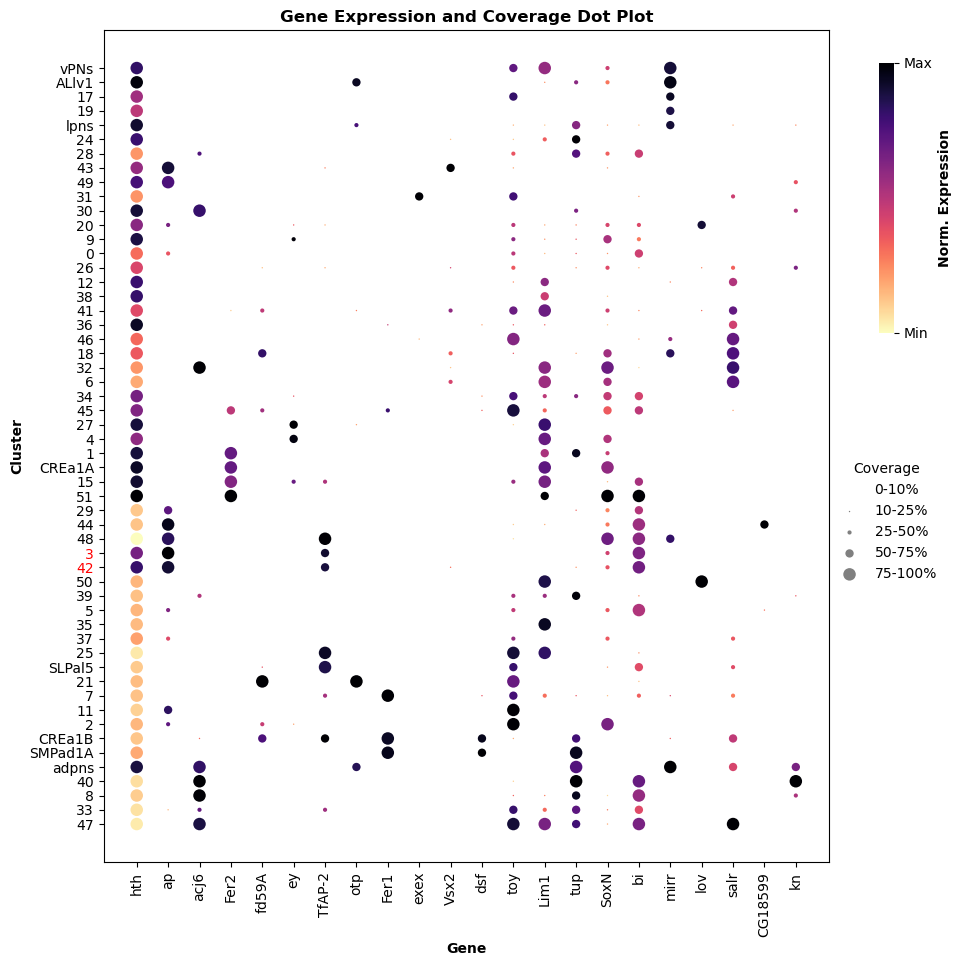

In [80]:
from scipy.cluster import hierarchy

# 1. Get the list of selected TFs from the previous step
# The 'gene_name' column from results_df is already ranked by importance
selected_tf_names = results_df['gene_name'].tolist()

# 2. Create a sub-matrix with only the selected TFs
# This matrix will be used to cluster the clusters
selected_tf_matrix = binary_matrix.loc[selected_tf_names]

# 3. Perform hierarchical clustering on the clusters (the columns)
# We transpose the matrix (.T) so that we are clustering the clusters, not the genes.
# 'ward' is a method that tends to create well-defined, tight clusters.
print("\nPerforming hierarchical clustering on clusters based on selected TFs...")
linkage_matrix = hierarchy.linkage(selected_tf_matrix.T, method='ward', metric='euclidean')

# Create a dendrogram object to get the optimal leaf order, but don't plot it
dendrogram = hierarchy.dendrogram(linkage_matrix, no_plot=True)

# The 'leaves' list in the dendrogram object gives the optimal order of indices
cluster_labels = selected_tf_matrix.columns
clustered_cluster_order = [cluster_labels[i] for i in dendrogram['leaves']]
print("Clustering complete. New cluster order determined.")

# 4. Prepare the data for plotting
# We only want to plot the data for the selected TFs
plot_subset = combined[combined['gene'].isin(selected_tf_names)]

# 5. Generate the dot plot with the new, clustered order
print("Generating dot plot with clustered order...")
dot_plot_fig_clustered = make_dot_plot(
    plot_subset,
    gene_order=selected_tf_names,      # Order genes by greedy search importance
    cluster_order=clustered_cluster_order, # Order clusters by similarity
    cmap='magma_r',
    highlight_clusters={'3', '42'}  # Highlight clusters '3' and '42' in red
)

plt.show()


Generating dot plot with clustered order...


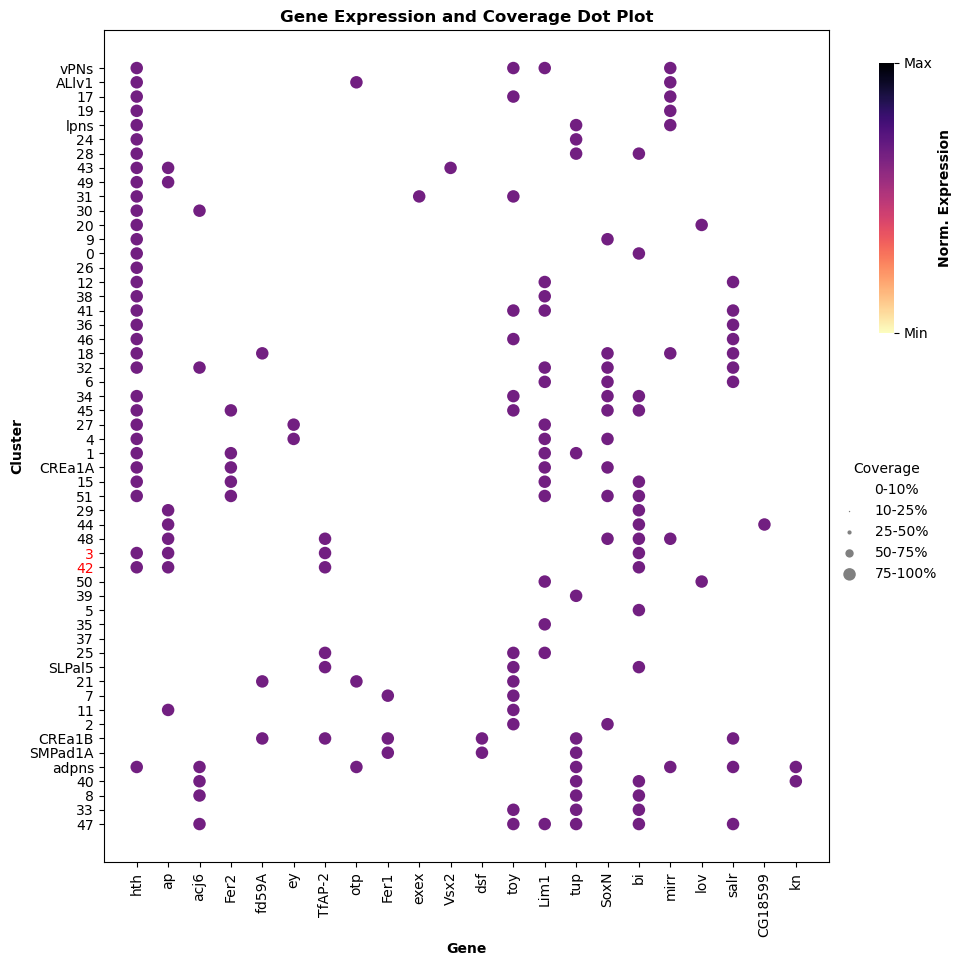

In [81]:
# plot a binary version for selected genes
print("Generating dot plot with clustered order...")
dot_plot_fig_clustered = make_dot_plot(
    plot_subset,
    hue_col='binary',
    coverage_col='binary',
    gene_order=selected_tf_names,      # Order genes by greedy search importance
    cluster_order=clustered_cluster_order, # Order clusters by similarity
    cmap='magma_r',
    highlight_clusters={'3', '42'}  # Highlight clusters '3' and '42' in red
)

plt.show()